# Imaging module tutorial

This tutorial shows how to convert DICOM into NRRD, check ROI segmentation, extract the radiomic features, and explore the imaging parameters.

Importing modules:

In [1]:
import os,sys
sys.path.append(os.path.abspath(".."))
from tool_box import tool_box
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb

%matplotlib inline

C:\Users\s.primakov\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\s.primakov\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\s.primakov\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
In C:\Users\s.primakov\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\s.primakov\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\s.primakov\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the '

## Data download

The Lung1 dataset (Aerts et al., 2014) contains pretreatment scans of 422 non-small cell lung cancer (NSCLC) patients, as well as manually deliniated gross tumor volume (GTV) for each patient, and clinical outcomes. More information you can find on the dataset web page and in the corresponding paper https://doi.org/10.1038/ncomms5006. For consistency, we recommend you to download the data to the '../data/dcms' folder of this project. You can find the data and its description (and the original paper) following the link below:
https://wiki.cancerimagingarchive.net/display/Public/NSCLC-Radiomics

To download the dataset, you might need to install the download manager: https://wiki.cancerimagingarchive.net/display/NBIA/Downloading+TCIA+Images#DownloadingTCIAImages-DownloadingtheNBIADataRetriever

Finally, you will have the '../data/dcms' folder with CT images (it will require 33 GB of disc space!).

## Dataset exploration

Setting the parameters:

In [2]:
parameters = {'data_path': r'../data/dcms/', # path_to_your_DICOM_data
              'data_type': 'dcm', # original data format: DICOM
              'multi_rts_per_pat': False}   # when False, it will look only for 1 rtstruct in the patient folder, 
                                            # this will speed up the process, 
                                            # if you have more then 1 rtstruct per patient, set it to True


Initialize the dataset:

In [3]:
data_dcms = tool_box(**parameters)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.95it/s]


Get the default metainformation from the DICOM files and print first 10:

In [4]:
dataset_description = data_dcms.get_dataset_description() 
dataset_description.head(10)

Patients processed: 100%|████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.18it/s]


,Modality,SliceThickness,PixelSpacing,SeriesDate,Manufacturer,patient,slice#
0,CT,3.0,"[0.9765625, 0.9765625]",20180209,SIEMENS,LUNG1-001_20180209_CT_2,0
1,CT,3.0,"[0.9765625, 0.9765625]",20180209,SIEMENS,LUNG1-001_20180209_CT_2,1
2,CT,3.0,"[0.9765625, 0.9765625]",20180209,SIEMENS,LUNG1-001_20180209_CT_2,2
3,CT,3.0,"[0.9765625, 0.9765625]",20180209,SIEMENS,LUNG1-001_20180209_CT_2,3
4,CT,3.0,"[0.9765625, 0.9765625]",20180209,SIEMENS,LUNG1-001_20180209_CT_2,4
5,CT,3.0,"[0.9765625, 0.9765625]",20180209,SIEMENS,LUNG1-001_20180209_CT_2,5
6,CT,3.0,"[0.9765625, 0.9765625]",20180209,SIEMENS,LUNG1-001_20180209_CT_2,6
7,CT,3.0,"[0.9765625, 0.9765625]",20180209,SIEMENS,LUNG1-001_20180209_CT_2,7
8,CT,3.0,"[0.9765625, 0.9765625]",20180209,SIEMENS,LUNG1-001_20180209_CT_2,8
9,CT,3.0,"[0.9765625, 0.9765625]",20180209,SIEMENS,LUNG1-001_20180209_CT_2,9


You can check for the needed info by printing unique values of the tags:

In [5]:
print('Unique modalities found: ', np.unique(dataset_description.Modality.values)[0])

Unique modalities found:  CT


There are two pre-set parameter dictionaries for 'CT' and 'MRI' with the extended amount of parameters, parsed from the DICOM tags. These parameters are specific for these imaging modalities. You can also send a custom list of parameters. In this case the DICOM tags should have the same names as corresponding pydicom (DICOM keyword, https://pydicom.github.io/pydicom/dev/old/base_element.html).

Get the CT-specific metainformation from the DICOM files and print first 10:

In [6]:
ct_dcms = tool_box(**parameters)
dataset_description = ct_dcms.get_dataset_description('CT') 
dataset_description.head(10)

Patients processed: 100%|████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.06it/s]


,PatientName,ConvolutionKernel,SliceThickness,PixelSpacing,KVP,Exposure,XRayTubeCurrent,SeriesDate,patient,slice#
0,LUNG1-001,B19f,3.0,"[0.9765625, 0.9765625]",120.0,400,80,20180209,LUNG1-001_20180209_CT_2,0
1,LUNG1-001,B19f,3.0,"[0.9765625, 0.9765625]",120.0,400,80,20180209,LUNG1-001_20180209_CT_2,1
2,LUNG1-001,B19f,3.0,"[0.9765625, 0.9765625]",120.0,400,80,20180209,LUNG1-001_20180209_CT_2,2
3,LUNG1-001,B19f,3.0,"[0.9765625, 0.9765625]",120.0,400,80,20180209,LUNG1-001_20180209_CT_2,3
4,LUNG1-001,B19f,3.0,"[0.9765625, 0.9765625]",120.0,400,80,20180209,LUNG1-001_20180209_CT_2,4
5,LUNG1-001,B19f,3.0,"[0.9765625, 0.9765625]",120.0,400,80,20180209,LUNG1-001_20180209_CT_2,5
6,LUNG1-001,B19f,3.0,"[0.9765625, 0.9765625]",120.0,400,80,20180209,LUNG1-001_20180209_CT_2,6
7,LUNG1-001,B19f,3.0,"[0.9765625, 0.9765625]",120.0,400,80,20180209,LUNG1-001_20180209_CT_2,7
8,LUNG1-001,B19f,3.0,"[0.9765625, 0.9765625]",120.0,400,80,20180209,LUNG1-001_20180209_CT_2,8
9,LUNG1-001,B19f,3.0,"[0.9765625, 0.9765625]",120.0,400,80,20180209,LUNG1-001_20180209_CT_2,9


Let's plot some of the scans parameters:

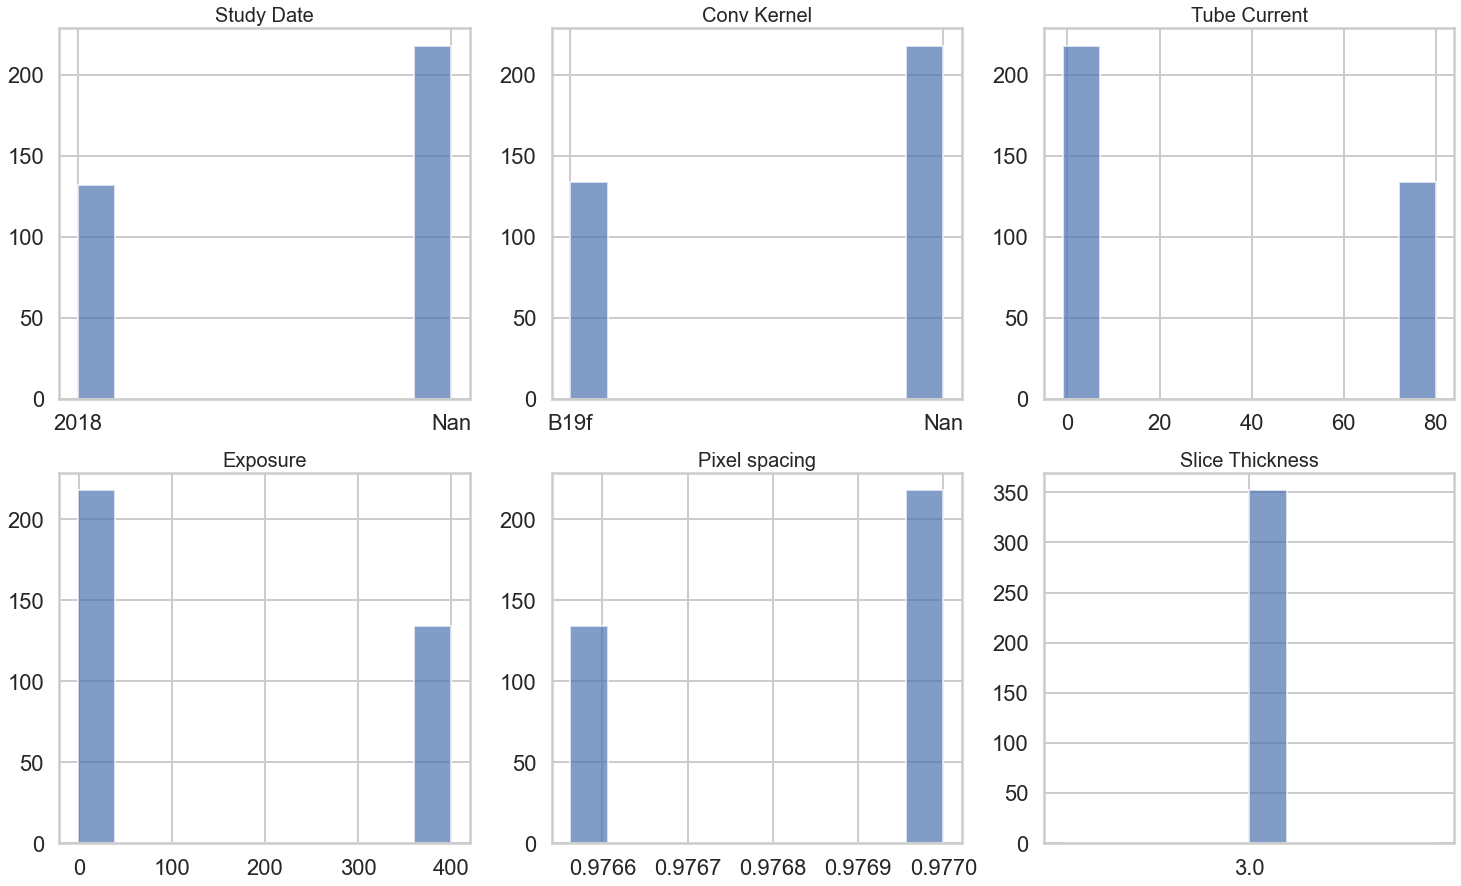

In [7]:
sb.set(context='poster', style='whitegrid')

study_date = sorted([ 'Nan' if x=='' or x=='NaN' else str(x[0:4]) for x in list(dataset_description['SeriesDate'])])[2:]
conv_kernel =['Nan' if x=='' or x=='NaN' else x for x in list(dataset_description['ConvolutionKernel'])]
tube_current =[-1 if x=='' or x=='NaN' else x for x in list(dataset_description['XRayTubeCurrent'])]
exposure =[-1 if x=='' or x=='NaN' else x for x in list(dataset_description['Exposure'])]
ps = sorted([(x[0]) for x in list(filter(lambda x: x != 'NaN', dataset_description['PixelSpacing'].values))])
sl_th = sorted([str(x)[0:3] for x in list(filter(lambda x: x != 'NaN', dataset_description['SliceThickness'].values))])
figures,descriptions = [study_date,conv_kernel,tube_current,exposure,ps,sl_th],['Study Date','Conv Kernel','Tube Current','Exposure','Pixel spacing','Slice Thickness']

fig,ax = plt.subplots(2,3,figsize=(25,15))
for i in range(2):
    for j in range(3):
        ax[i,j].hist(figures.pop(0),alpha=0.7)
        ax[i,j].set_title(descriptions.pop(0),fontsize=20)

## Quality control step

In [8]:
##blah blah blah

In [9]:
#set parameters for the script
qc_params = {'specific_modality': 'ct',
            'thickness_range': [2,5],
            'spacing_range': [0.5,1.25],
            'scan_length_range': [5,170],
            'axial_res': [512,512],
            'kernels_list': ['standard','lung','b19f']} 

In [10]:
qc_dataframe = ct_dcms.get_quality_checks(qc_parameters=qc_params, verbosity=True)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

Modality check status: 1
Number of slices check status: 1
Pixel spacing in acceptable range check status: 1
Axial plane check status: 1


 33%|████████████████████████████                                                        | 1/3 [00:00<00:01,  1.01it/s]

Intercept/slope check status: 1
Image shape is [512, 512] check status 1
Slice thickness consistency check status: 1
Slice thickness in acceptable range check status: 1
Missing/overlapping slices check status: 1
Conv Kernel check status: 1
Modality check status: 1
Number of slices check status: 1
Pixel spacing in acceptable range check status: 1
Axial plane check status: 1


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:01,  1.00s/it]

Intercept/slope check status: 1
Image shape is [512, 512] check status 1
Slice thickness consistency check status: 1
Slice thickness in acceptable range check status: 1
Missing/overlapping slices check status: 1
Cannot perform conv kernel check for pat: LUNG1-002_20180526_CT_1
Modality check status: 1
Number of slices check status: 1
Pixel spacing in acceptable range check status: 1
Axial plane check status: 1


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.03it/s]

Intercept/slope check status: 1
Image shape is [512, 512] check status 1
Slice thickness consistency check status: 1
Slice thickness in acceptable range check status: 1
Missing/overlapping slices check status: 1
Cannot perform conv kernel check for pat: LUNG1-003_20180209_CT_1


In [11]:
qc_dataframe

,Patient id,Modality is acceptable,Projection is axial,Complete scan (no missing/overlapping slices),Scan len is in range,Slice thickness is in range,Slice thickness is consistent,Pixel spacing is in range,Convolutional kernel tag is present,Convolutional kernel is acceptable,Axial pr. resolution is acceptable,Intensity intercept/slope tags are present
0,LUNG1-001_20180209_CT_2,1,1,1,1,1,1,1,1,1,1,1
1,LUNG1-002_20180526_CT_1,1,1,1,1,1,1,1,0,NaN,1,1
2,LUNG1-003_20180209_CT_1,1,1,1,1,1,1,1,0,NaN,1,1


##  DICOM to NRRD conversion

To convert DICOM dataset to the volume (nrrd) format, set up the parameters:  

* '*export_path = ...*' export path where the converted NRRDs will be placed,  
* '*region_of_interest = ...*' if you know exact name of the ROI you want to extract, then write it with the '!' character in front, eg. '*region_of_interest = !gtv1*',
* if you want to extract all the GTVs in the rtstruct eg. '*gtv1*', '*gtv2*', '*gtv_whatever*', then just specify the stem word, eg. '*region_of_interest = gtv*', 
* default value is '*region_of_interest ='all'*', where all ROI's in rtstruct will be extracted.

In [12]:
export_path =r'../data/' # the function will create 'converted_nrrd' folder in the specified directory


Initialize the dataset (originally downloaded directory with DICOM files):

In [13]:
data_ct = tool_box(**parameters) 

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.72it/s]


Run the conversion:

In [14]:
data_ct.convert_to_nrrd(export_path, 'gtv')

Patients converted: 100%|████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.60s/it]


## Quick check of the ROI's in the NRRD dataset

If you want to check your converted images & ROIs, or just any volumetric dataset (NRRD/MHA), you can use get_jpegs function of the toolbox. It will generate JPEG images for each slice with the image and overlap of the contour.

Initialize the dataset (converted NRRD files):

In [15]:
data_ct_nrrd = tool_box(data_path = r'../data/converted_nrrds/', data_type='nrrd')

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 999.91it/s]


Run the visualization:

In [16]:
data_ct_nrrd.get_jpegs(r'../data/') # the function will create 'images_quick_check' folder in the specified directory 

Patients processed: 100%|████████████████████████████████████████████████████████████████| 5/5 [01:02<00:00, 12.56s/it]


Let's check one of the patients:

In [17]:
from ipywidgets import interact
import numpy as np
from PIL import Image

def browse_images(images,names):
    n = len(images)
    def view_image(i):
        plt.figure(figsize=(20,10))
        plt.imshow(images[i])#, cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title('Slice: %s' % names[i])
        plt.axis('off')
        plt.show()
    interact(view_image, i=(0,n-1))
    
for pat,_ in data_ct_nrrd:
    _,file_struct = [*os.walk(os.path.join('../data/images_quick_check/',pat))]
    root,images = file_struct[0],file_struct[2]
    imgs =[np.array(Image.open(os.path.join(root,img))) for img in images]
    print(pat)
    browse_images(imgs,images)
    break

LUNG1-001_20180209_CT_2_GTV-1_mask


interactive(children=(IntSlider(value=10, description='i', max=20), Output()), _dom_classes=('widget-interact'…

## Image pre-processing

Initialize the dataset (converted NRRD files):

In [18]:
data_ct_nrrd = tool_box(data_path = r'../data/converted_nrrds/',
                    data_type='nrrd')

100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 2979.61it/s]


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

----------------------------------------
Original image stats:
Number of unique intensity values : 3033
Intensity values range:[-1024:3034]
Image intensity dtype: int16
----------------------------------------


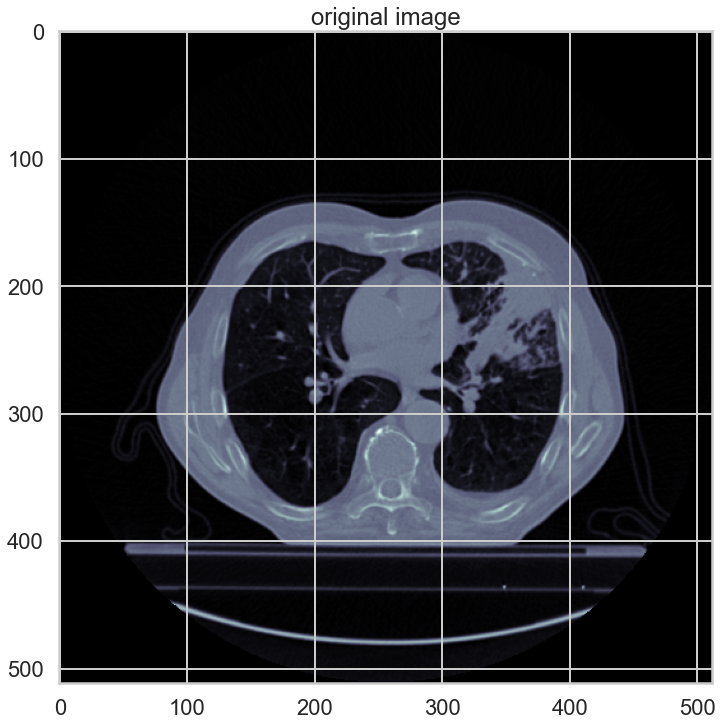

Resampling with a step of:  134.0 Amount of unique values, original img:  3033 resampled img:  15
----------------------------------------
Intensity values resampled with a number of bins: 15
----------------------------------------


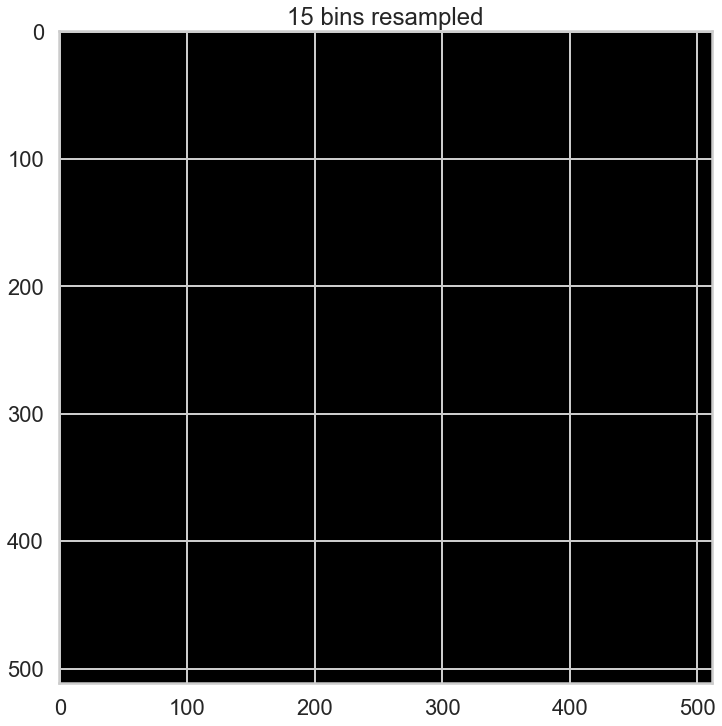

Histogram equalization applied


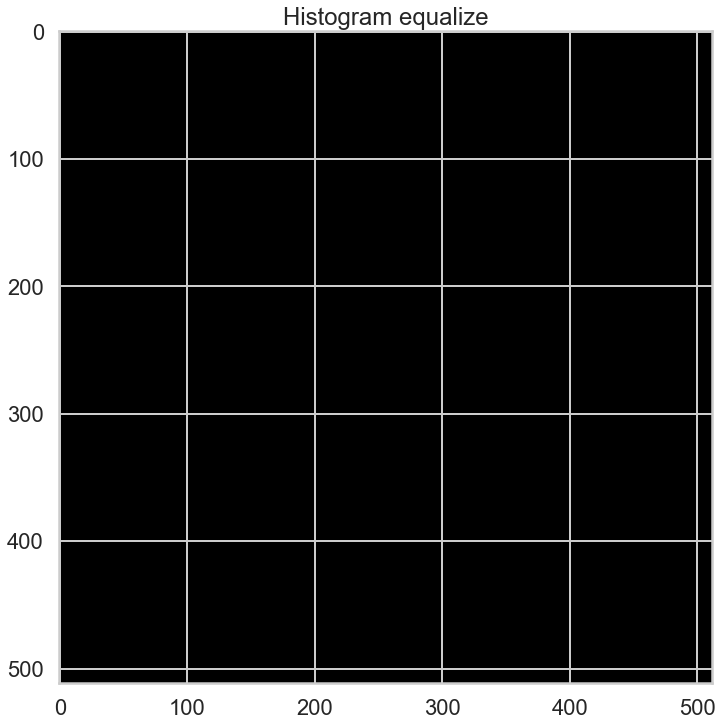

Z-score normalization applied based on the whole image, Mu=1000.0, sigma=500.0


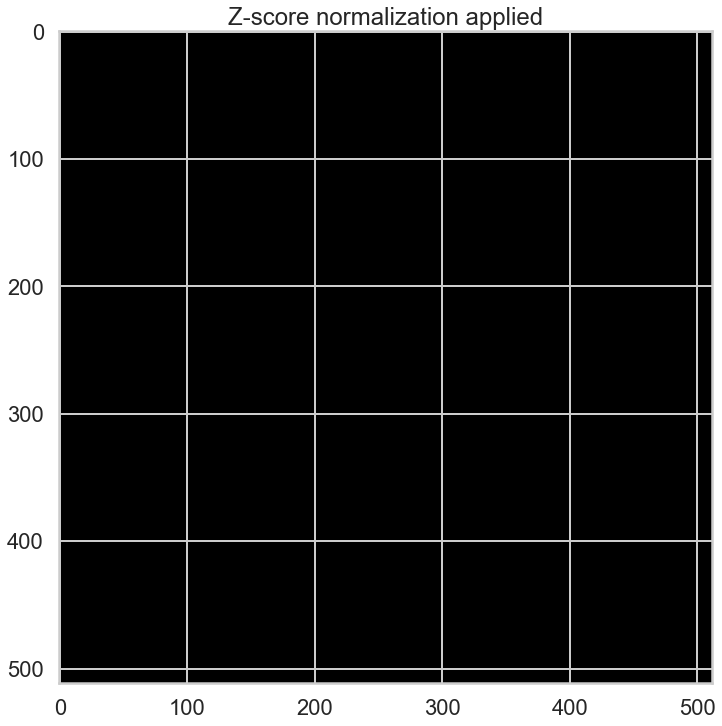

 20%|████████████████▊                                                                   | 1/5 [00:08<00:35,  8.85s/it]

----------------------------------------
Original image stats:
Number of unique intensity values : 3019
Intensity values range:[-1024:3071]
Image intensity dtype: int16
----------------------------------------


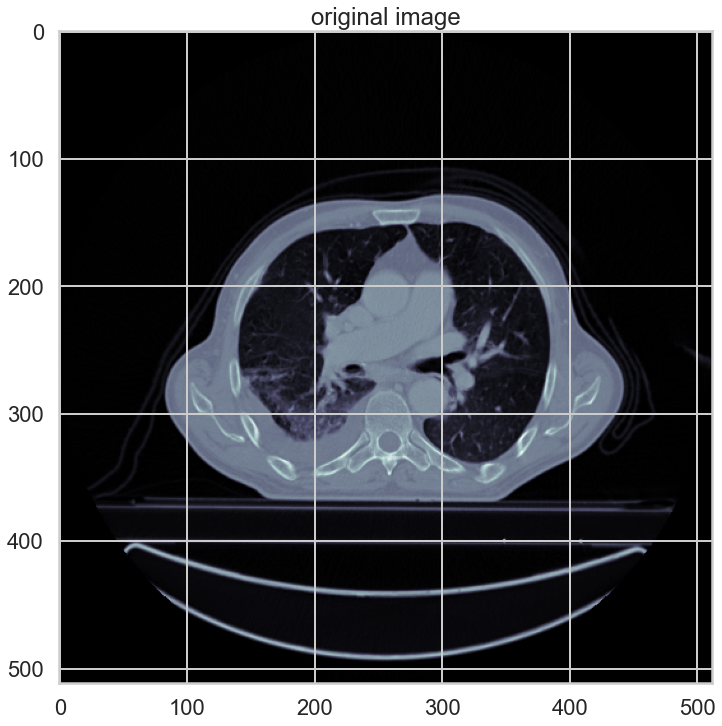

Resampling with a step of:  136.46666666666667 Amount of unique values, original img:  3019 resampled img:  15
----------------------------------------
Intensity values resampled with a number of bins: 15
----------------------------------------


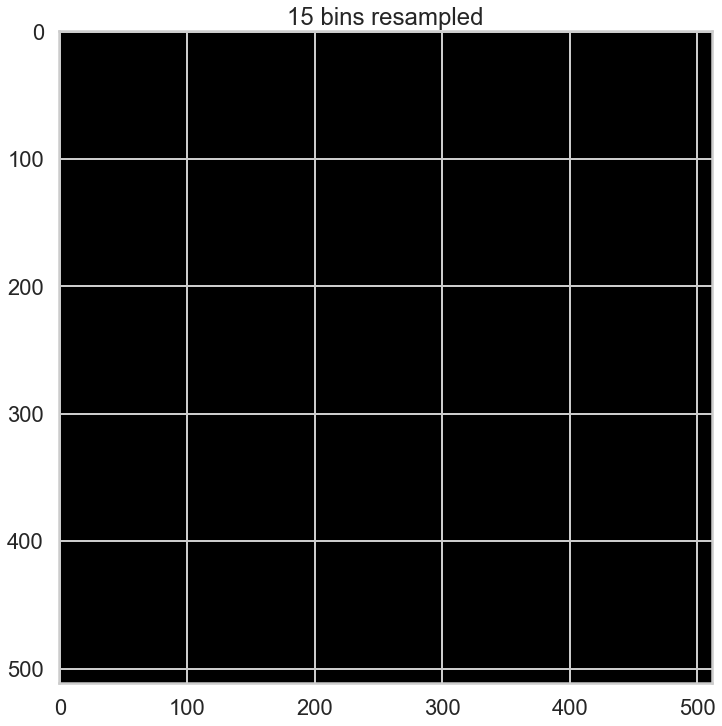

Histogram equalization applied


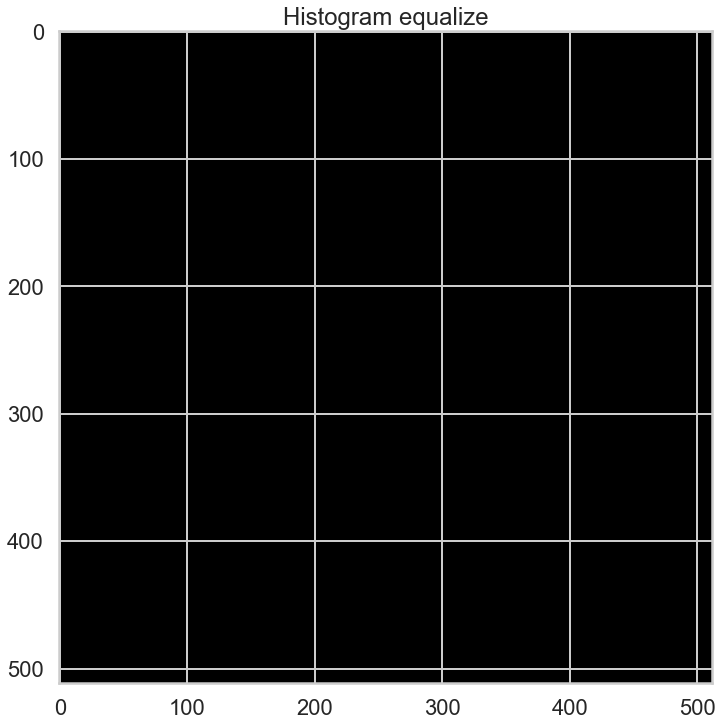

Z-score normalization applied based on the whole image, Mu=1000.0, sigma=500.0


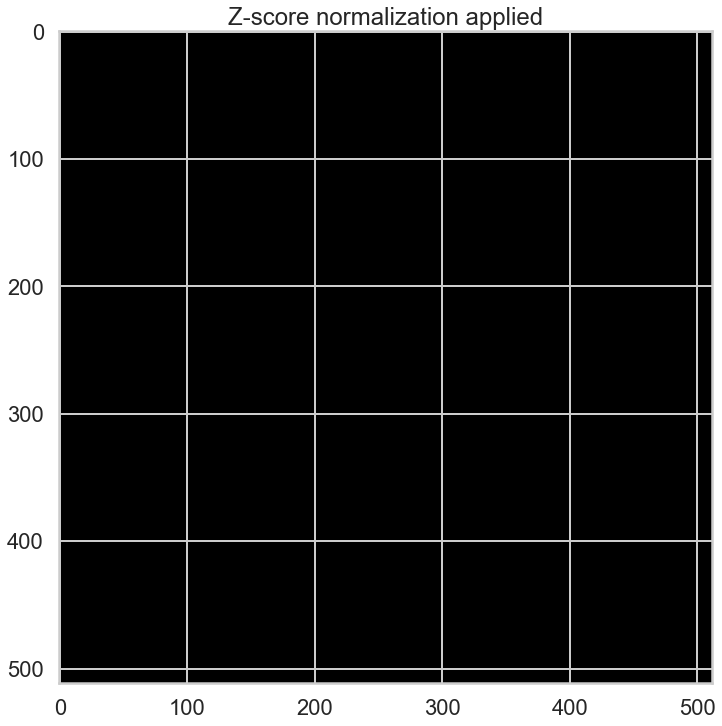

 40%|█████████████████████████████████▌                                                  | 2/5 [00:16<00:25,  8.62s/it]

----------------------------------------
Original image stats:
Number of unique intensity values : 3829
Intensity values range:[-1024:3071]
Image intensity dtype: int16
----------------------------------------


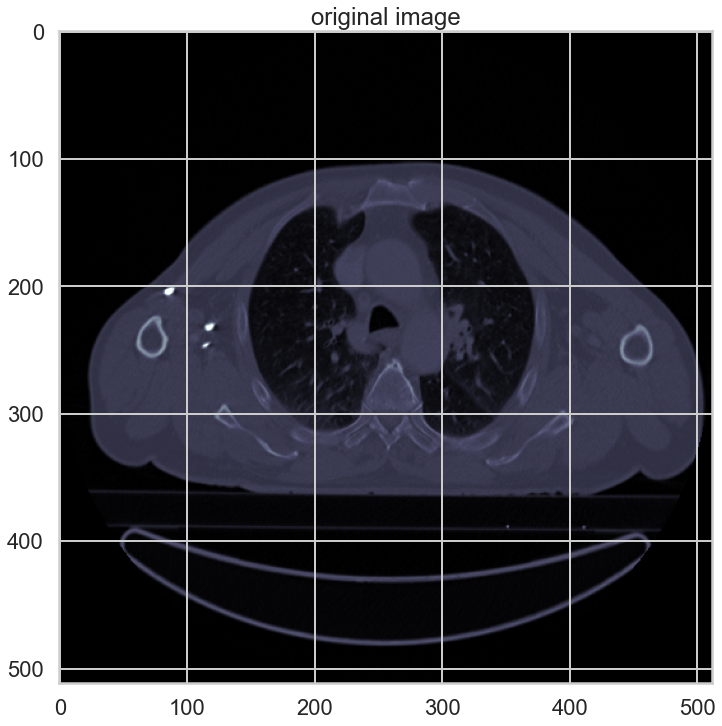

Resampling with a step of:  136.46666666666667 Amount of unique values, original img:  3829 resampled img:  15
----------------------------------------
Intensity values resampled with a number of bins: 15
----------------------------------------


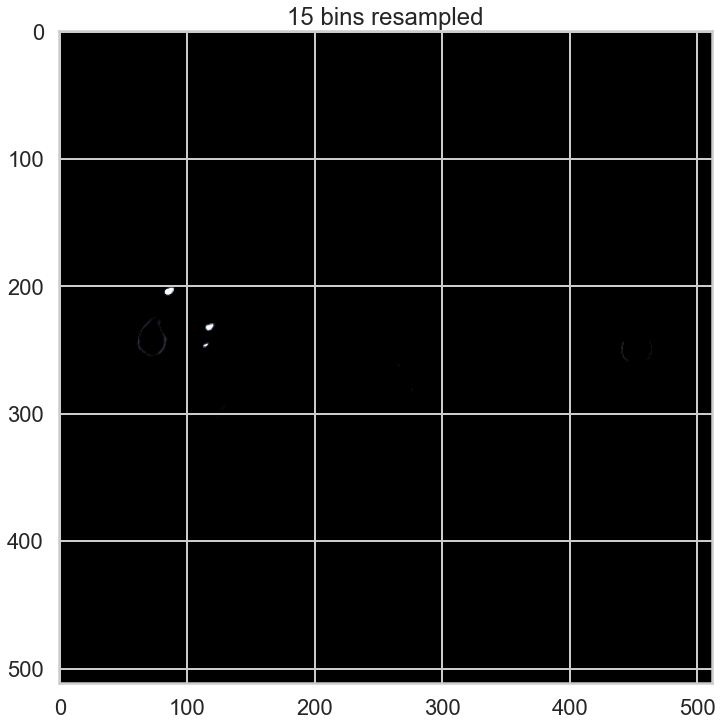

Histogram equalization applied


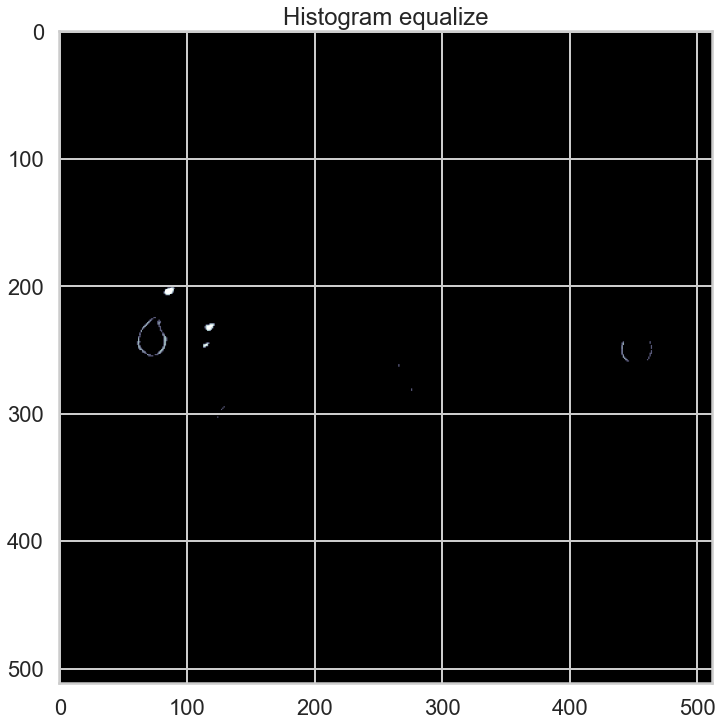

Z-score normalization applied based on the whole image, Mu=1000.0, sigma=500.0


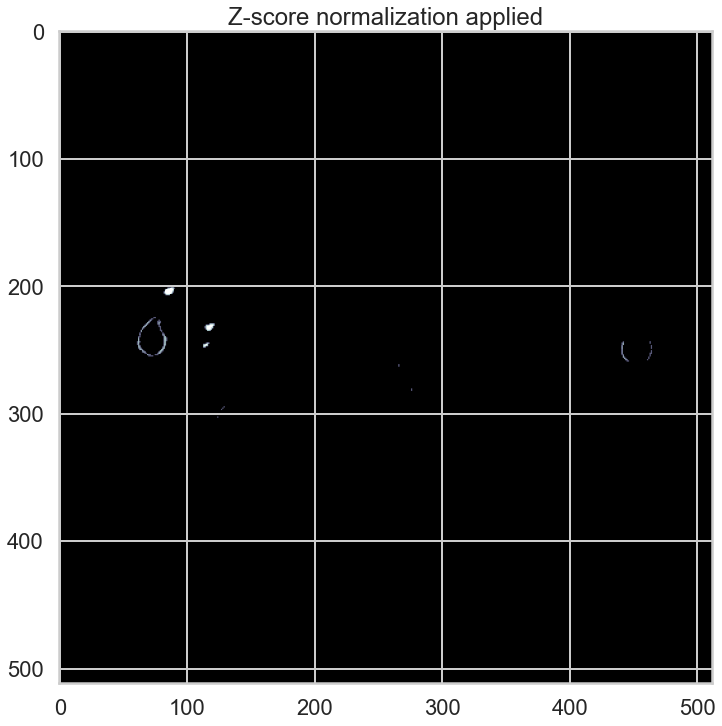

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:25<00:17,  8.54s/it]

----------------------------------------
Original image stats:
Number of unique intensity values : 3829
Intensity values range:[-1024:3071]
Image intensity dtype: int16
----------------------------------------


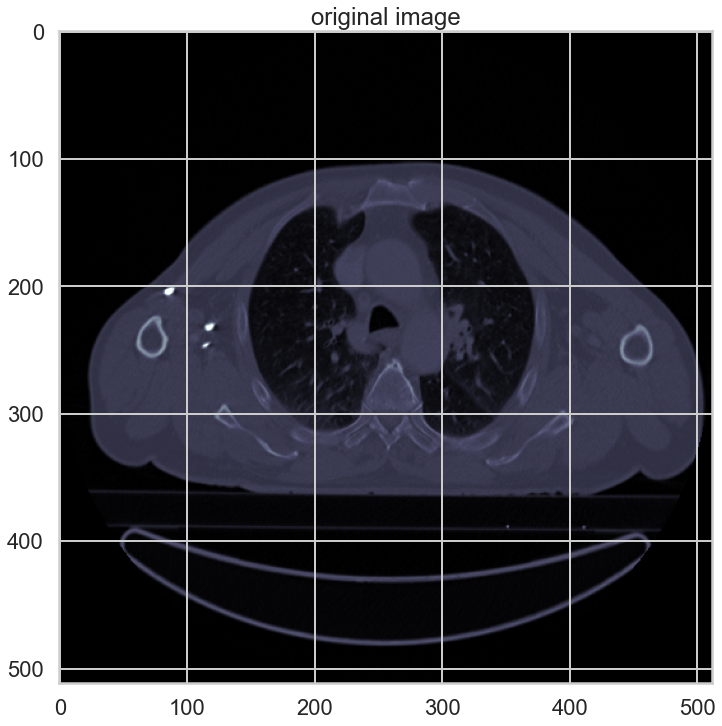

Resampling with a step of:  136.46666666666667 Amount of unique values, original img:  3829 resampled img:  15
----------------------------------------
Intensity values resampled with a number of bins: 15
----------------------------------------


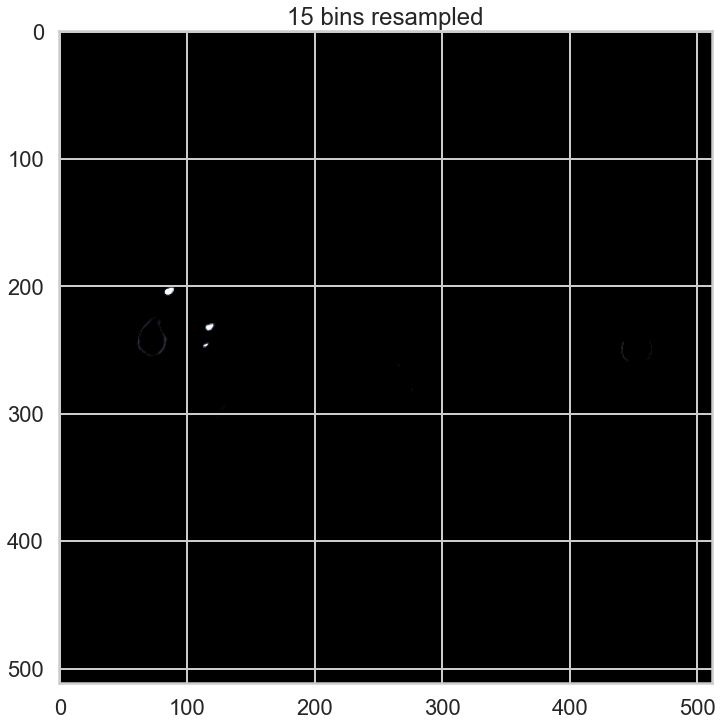

Histogram equalization applied


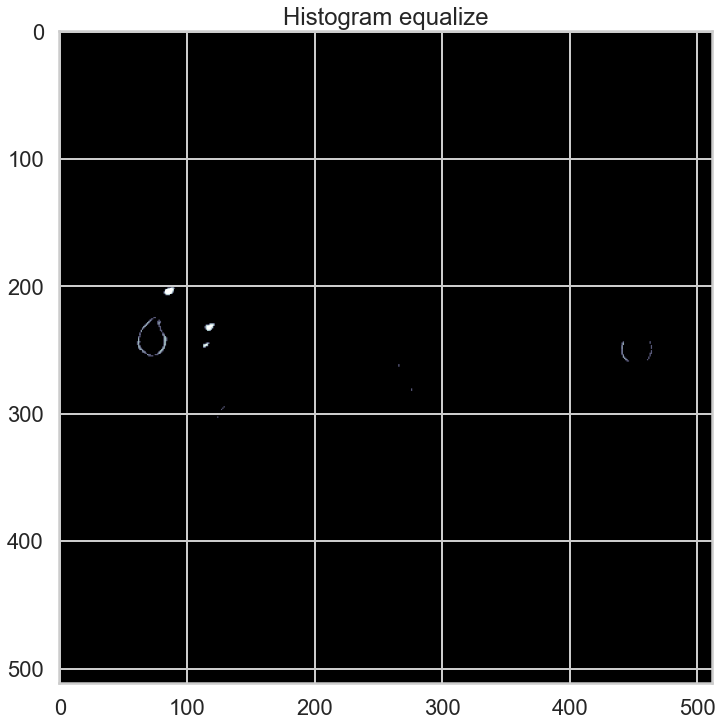

Z-score normalization applied based on the whole image, Mu=1000.0, sigma=500.0


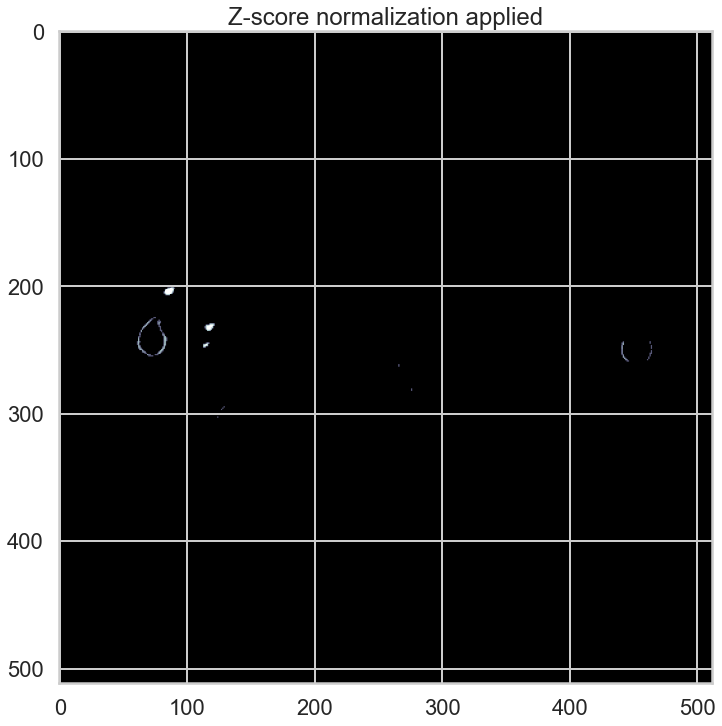

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:32<00:08,  8.15s/it]

----------------------------------------
Original image stats:
Number of unique intensity values : 3829
Intensity values range:[-1024:3071]
Image intensity dtype: int16
----------------------------------------


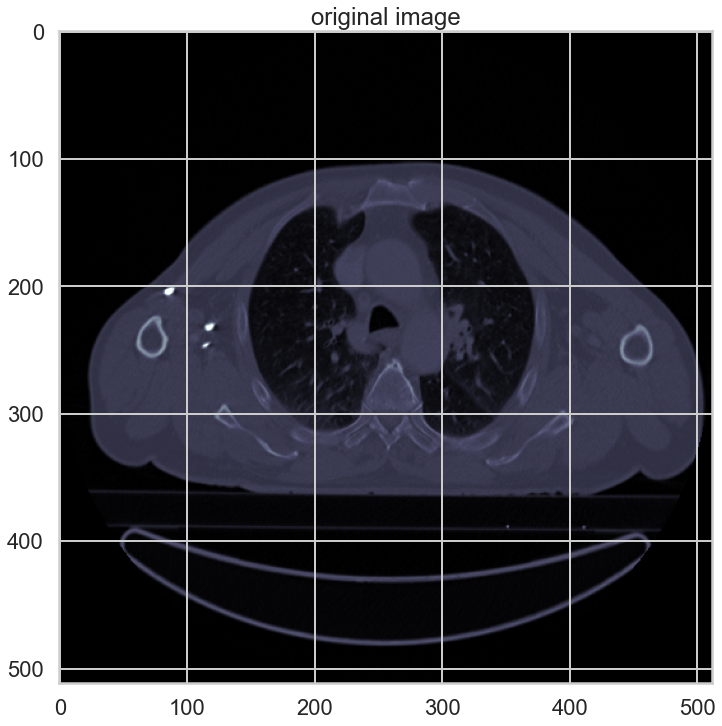

Resampling with a step of:  136.46666666666667 Amount of unique values, original img:  3829 resampled img:  15
----------------------------------------
Intensity values resampled with a number of bins: 15
----------------------------------------


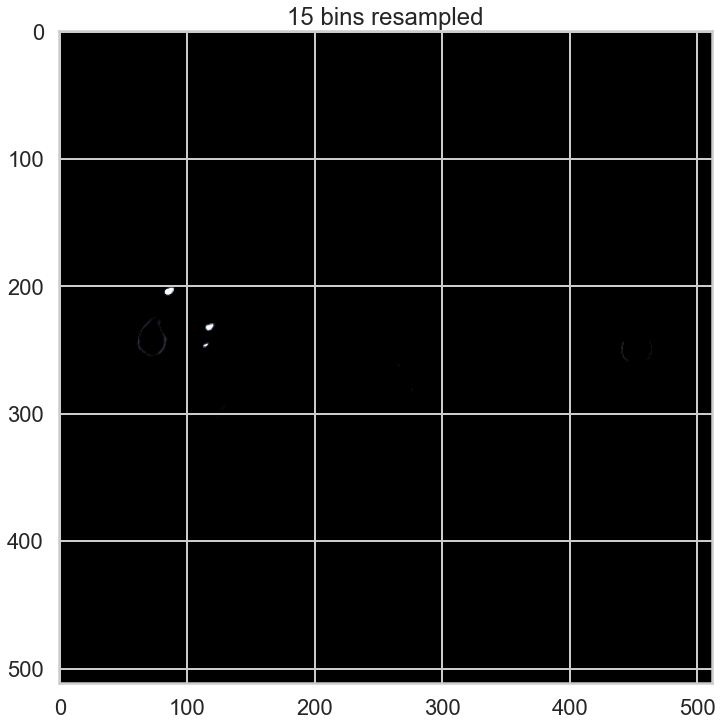

Histogram equalization applied


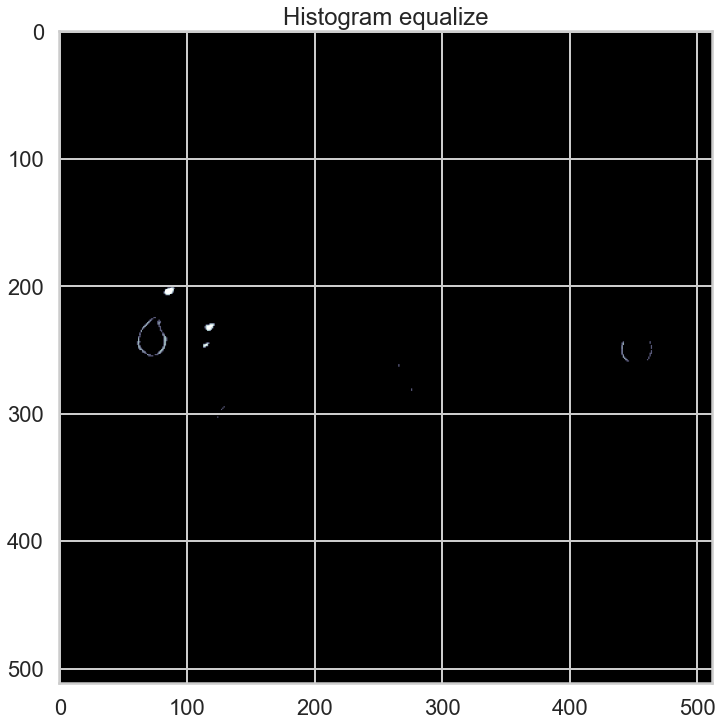

Z-score normalization applied based on the whole image, Mu=1000.0, sigma=500.0


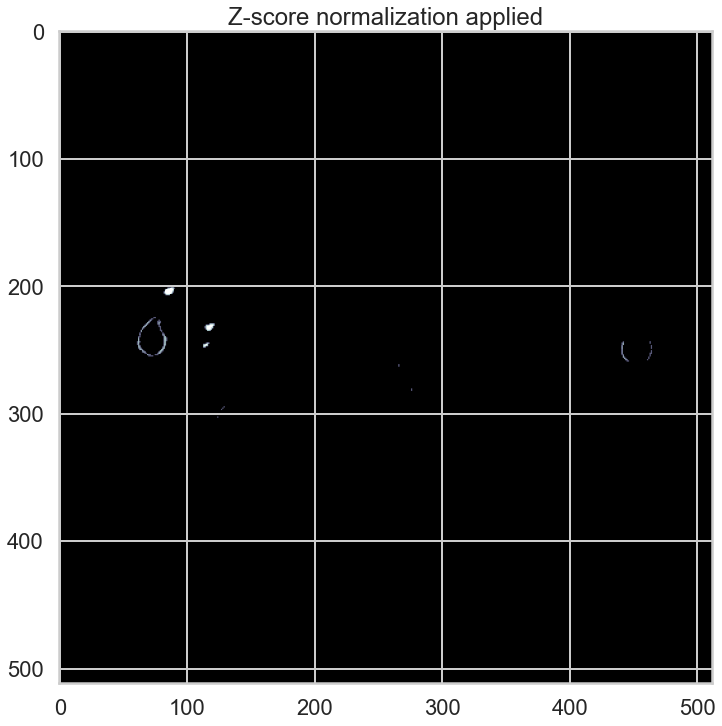

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.19s/it]


In [23]:
data_ct_nrrd.pre_process(ref_img_path = '../data/converted_nrrds/LUNG1-001_20180209_CT_2/image.nrrd',
                         save_path = '../data/nrrd_preprocessed',
                         hist_match = False,        # boolean
                         subcateneus_fat = False,   # boolean
                         fat_value = 774,           # this is a dummy value, 
                                                    # you would need to find that value for each image
                         percentile_scaling = False, # boolean
                         binning = 255,             # this is a dummy value, it takes False or int 
                                                    # (# of bins for intensity resampling)
                         verbosity = True,          # boolean
                         z_score = True,           # boolean 
                         hist_equalize = True,     # boolean
                         norm_coeff = (1000.,500.), # these are dummy values, you would need to estimate real mu and sigma
                                                    # it takes None or tuple: (mu,sigma)
                         visualize = True)

## PyRadiomics features extraction

In our toolbox, we are using PyRadiomics software (https://pyradiomics.readthedocs.io/en/latest/) to extract the features. You can read the full documentation for the currently stable version: https://pyradiomics.readthedocs.io/_/downloads/en/stable/pdf/.

We are using PyRadiomics parameters file customized for CT data:

In [ ]:
parameters = r"example_ct_parameters.yaml"
features = data_ct_nrrd.extract_features(parameters, loggenabled=True)

Printing the features for first 3 ROIs:

In [ ]:
features.head(3)

Writing the features into the Excel file (you will find it in the 'data/features' folder):

In [ ]:
writer = pd.ExcelWriter('../data/features/extracted_features.xlsx') 
features.to_excel(writer, 'Sheet1')
writer.save()